# The No U-Turn Sampler

Hoffman & Gelman 2011: The No U-Turn Sampler
* implement algorithms 1 (basic HMC) & 6 (NUTS with dual averaging)
* test that your implementations work by replicating the following tests in Section 4.1:
 * 250-dimensional Gaussian
 * Bayesian logistic regression & hierarchical Bayesian logistic regression on the UCI german credit data
 * compare the results given by basic HMC & NUTS
 * compare your results with the same models run in Stan using the provided NUTS sampler
  * see e.g. mc-stan.org/users/interfaces/pystan.html

## General notes
Both the No-U-turn sampler and the HMC sampler only return latter half of the sample.
I've aimed at a between 50 and 60 percent acceptance rate for the accepted half.

To avoid variable names overlapping, each part resets the variables.

Functions for checking the convergence:
- ChainMix.py: between- and within chains mixing (BDA3, p. 284, formula 11.3); every chain is splitted into two halves, as the writers suggest in the footnote on p. 285

## Algorithm 1: Basic hamiltonian Monte Carlo
file: HMC.py

## Algorithm 6: Efficient No-U-Turn sampler
file: noUturnSampler.py

# Test case 0: simple linear regression
First test is a simple linear regression with coefficients alpha=theta[0]=10 and
beta=theta[1]=5. This test is for to roughly see that the sampler works.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


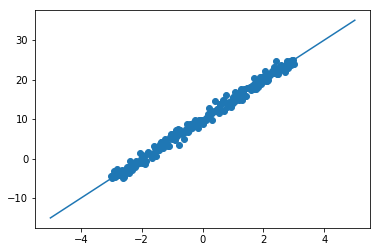

In [3]:
%reset
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt
import noUturnSampler
import HMC
# Always import the newest version of the samplers
import importlib
importlib.reload(noUturnSampler)
importlib.reload(HMC)

def LikelihoodTest0(theta, x, y, sigma2=1.0):
    return np.sum(-1/(2*sigma2)*(y-theta[0]-theta[1]*x)**2)

test0x=np.linspace(-3, 3, 200)
test0y=10+5*test0x+npr.normal(size=200)
# beta values for data generation are: [10, 5]
plt.scatter(test0x,test0y)
plt.plot(np.linspace(-5,5,200), 10+5*np.linspace(-5,5,200))

SimpleRegression=lambda x: LikelihoodTest0(x, test0x, test0y, sigma2=1.0)

### HMC

All in all accepted:  1000.0 , proportion:  1.0
Accepted:  499.0
Acceptance rate:  0.998
alpha:  9.939950150229771 beta:  5.040532850961048


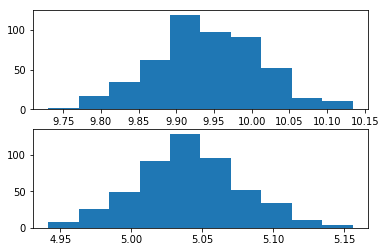

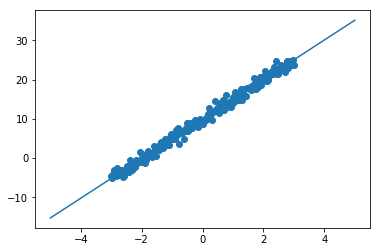

In [4]:

test0theta, test0r = HMC.basicHmc(np.array([-10.0, -10.0]), 0.001, 40, SimpleRegression, 1000)

print('alpha: ', np.mean(test0theta[:,0]), 'beta: ', np.mean(test0theta[:,1]))
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) # two axes on figure
ax2.hist(test0theta[:, 0])
ax3.hist(test0theta[:,1])

fig3, (plot1) = plt.subplots(nrows=1, ncols=1)
plot1.plot(np.linspace(-5,5,200), np.mean(test0theta[:,0])+np.mean(test0theta[:,1])*np.linspace(-5,5,200))
plt.scatter(test0x, test0y)

### No-U-Turn sampler

In [8]:
# def NoUTurn(theta0, delta, fLikelihood, nSamples, nSamplesAdapt)
sample0UTurn, epsilonHist0=noUturnSampler.NoUTurn(np.array([-10.0,-10.0]), 0.60, SimpleRegression, 2000,1000, testRun=False)

C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Computational statistics II\noUturnSampler.py:137: RuntimeWarning: invalid value encountered in double_scalars
  if npr.uniform()<nCur2/(nCur+nCur2):


Alpha value:  9.954650277155988
Beta value:  5.039314827553434


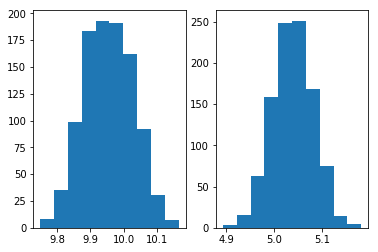

In [9]:
fig3, (plot1,plot2) = plt.subplots(nrows=1, ncols=2)
plot1.hist(sample0UTurn[:,0])
plot2.hist(sample0UTurn[:,1])
print('Alpha value: ',np.mean(sample0UTurn[:,0]))
print('Beta value: ', np.mean(sample0UTurn[:,1]))

# Bayesian logistic regression

Metadata from Harvard data verse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/Q8MAW8

Original data from: https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data), using the file "german.data-numeric" version produced by Strathclyde University. Changes made: 
- changed the ordering of Attribute 3 (Credit History) to try to extract monotone relationship: ORIGINAL ORDERING: A30 : no credits taken/all credits paid back duly, A31 : all credits at this bank paid back duly, A32 : existing credits paid back duly till now, A33 : delay in paying off in the past, A34 : critical account/other credits existing (not at this bank)) NEW ORDERING: 0=all credits paid back (A31) 1=all credits paid back duly til now (A32) 2= no credits taken (A30) 3= delay in past (A33) 4=critical acct (A34). 


ATTRIBUTES: 
1 BalanceCheque
2 Loan NurnMonth
3 CreditHistory 
4 CreditAmt 
5 SavingsBalance 
6 Mths in PresentEmployment 
7 PersonStatusSex 
8 PresentResidenceSince 
9 Property 
10 AgeInYears 
11 OtherInstallmentPlans (highest val is NO other installment plans) 
12 NumExistingCreditsThisBank 
13 NumPplLiablMaint 
14 Telephone 
15 ForeignWorker 
16 Purpose-CarNew 
17 Purpose-CarOld 
18 otherdebtor-none (compared to guarantor) 
19 otherdebt-coappl (compared to guarantor) 
20 house-rent (compared to 'for free') 
21 house-owns (compared to 'for free') 
22 job-unemployed (vs mgt) 
23 jobs-unskilled (vs mgt) 
24 job-skilled (vs mgt) 

In [154]:
%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)

credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)
#print(credit0.shape)
creditY=np.array(credit0['CREDITRATING'])
# Add alpha column=1.0 to make calculations easier
credit0.insert(0, 'alpha', np.ones(len(credit0)))
creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
#print(creditX0[:5,0])
#print('X mean before standardizing: ', np.mean(creditX0, axis=0))
#print('X std before standardizing: ', np.std(creditX0, axis=0))
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)
creditX[:,0]=1.0
#print('creditX0 shape: ',creditX0.shape)
#print('X mean: ', np.mean(creditX,axis=0))
#print('X std: ', np.std(creditX, axis=0))
#print('Y shape: ', creditY.shape)
#print('X shape: ', creditX.shape)
#print('Distinct y values: ', np.unique(creditY))

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [155]:
print(creditX.shape, creditY.shape)
# Solve beta values for comparison
logistic = LogisticRegression(fit_intercept=False)
betaCoefficients=logistic.fit(creditX,creditY).coef_

(1000, 25) (1000,)


In [156]:
"""
theta: coefficients that are estimated
creditX: independent variables; matrix from the data
creditY: dependent variable; matrix from the data
sigma2: theta (intercept at index 0 and coefficients) is given zero mean
        normal priors and variance of 100
output: lProb is the log probability for theta
"""
def lBayesLR(theta, x, y, sigma2=100):    
    lProb=-np.sum(np.log(1+np.exp(-y*(x@theta))))-1/(2*sigma2)*theta@theta
    return lProb
    
lBayesLRX=lambda theta0: lBayesLR(theta0, creditX, creditY)

## HMC

In [157]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(25)
thetaOriginal2=npr.normal(-10.0, 5.0, 25)
thetaOriginal3=npr.normal(10.0, 5.0, 25)
thetaOriginal4=npr.normal(0.0, 5.0, 25)

# Sample size*2 (only the latter half is returned)
size=200
hmcTheta0=np.empty([size//2, 25, 4])
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.08, 20, lBayesLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.08, 20, lBayesLRX, size)

All in all accepted:  107.0 , proportion:  0.535
Accepted:  50.0
Acceptance rate:  0.5
All in all accepted:  117.0 , proportion:  0.585
Accepted:  61.0
Acceptance rate:  0.61
All in all accepted:  114.0 , proportion:  0.57
Accepted:  62.0
Acceptance rate:  0.62
All in all accepted:  109.0 , proportion:  0.545
Accepted:  50.0
Acceptance rate:  0.5


### HMC: Chain mixing
RHat statistic describes the relation of between- and within-chain variances. Its value is 1 if the chains are perfectly mixed, but value 1.1 (as mentioned is the lecture notes) is considered to be sufficient as a an indicator for the convergence.

RHat statistics for the parameters are:  [8.71698829 6.65901001 3.74767396 2.70000164 1.48897895 2.93192518
 1.60144003 1.5539341  1.09568477 1.6830648  1.28473077 3.07877152
 1.71773975 1.14466878 1.61696592 2.03316273 2.75406892 1.96711334
 2.24693137 2.26096471 1.19427751 1.05720195 1.21545487 1.0211273
 1.01212171]


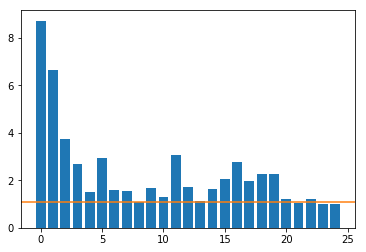

In [158]:
import ChainMix
importlib.reload(ChainMix)

hmcTheta1=np.zeros([size//4, 25, 8])
for i in range(4):
    hmcTheta1[:,:,i]=hmcTheta0[:size//4,:,i]
    hmcTheta1[:,:,i+1]=hmcTheta0[size//4:,:,i]

rHat=ChainMix.ChainMix(hmcTheta1)
print('RHat statistics for the parameters are: ', rHat)
plt.bar(range(len(rHat)),height=rHat)
plt.axhline(y=1.1, color='tab:orange')

### HMC: Effective sample size
BDA3 suggests that sufficient effec
tive sample size is at least 5m, so that there is at least 10 independent draws per sequence. (p 287)

vt0 (50, 25, 8)
tt (50,)
Effective sample size:  [ 4.00749824  4.04596542  4.23219466  4.44157126  6.60195099  4.379708
  6.02015686  6.36411251 17.55924253  5.80482753  8.88574677  4.39793427
  5.4412745  11.15110695  5.72124873  4.97329747  4.43336216  5.03556399
  4.91336314  4.75925887 10.13673322 15.01248082  8.89101979 22.44611908
 20.10465565]


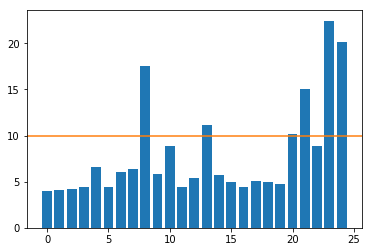

In [159]:
hmcEff=Neff.Neff(hmcTheta1)
print('Effective sample size: ', hmcEff)
plt.bar(range(len(hmcEff)),height=hmcEff)
plt.axhline(y=10.0, color='tab:orange')

### HMC: Comparison with frequentist logistic regression coefficients

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]
sample coefficients:  [-7.63620754e-01 -4.74152767e-01  2.84930137e-01 -2.44628600e-01
  8.86346126e-02 -2.30998092e-01 -1.10662262e-01 -7.53626400e-02
  2.18532685e-02  1.10511694e-01 -6.29748097e-02 -1.56227092e-01
  1.02972815e-01 -6.86385128e-03 -8.78145630e-02 -1.90088773e-01
  1.65529110e-01 -2.03393556e-01  2.08575528e-01  1.71177769e-01
  8.10339527e-02 -2.92871206e-02 -4.92858706e-02 -9.79504707e-03
  6.50649802e-04]
absolute difference of the coefficients:  [[0.4  0.25 0.13 0.14 0.06 0.13 0.07 0.08 0.01 0.07 0.04 0.08 0.07 0.04
  0.04 0.06 0.1  0.1  0.09 0.08 0.04 0.03 0.03 0.01 0.01]]
(25,)


Text(0.5,1,'Absolute difference of logistic regression coefficients')

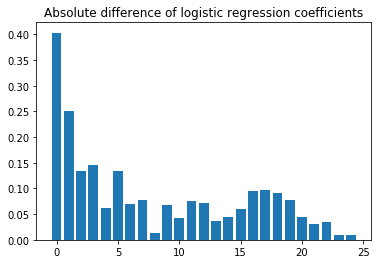

In [167]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
hmcCoefficients=np.mean(hmcTheta1, axis=(0,2))
print('sample coefficients: ', hmcCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-hmcCoefficients), 2))
height0=abs(betaCoefficients-hmcCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')

## NUTS sampler 

In [161]:
# Reload noUturnSampler-script always anew.
import noUturnSampler
import importlib
importlib.reload(noUturnSampler)

# Sample size*2 (only the latter half is returned)
size=2000
nutsTheta0=np.empty([size//2, 25, 4])

nutsTheta0[:,:,0], nutsEpsilon1 = noUturnSampler.NoUTurn(thetaOriginal1, 0.6, lBayesLRX, size,size//2, testRun=False)
nutsTheta0[:,:,1], nutsEpsilon2 = noUturnSampler.NoUTurn(thetaOriginal2, 0.6, lBayesLRX, size,size//2, testRun=False)
nutsTheta0[:,:,2], nutsEpsilon3 = noUturnSampler.NoUTurn(thetaOriginal3, 0.6, lBayesLRX, size,size//2, testRun=False)
nutsTheta0[:,:,3], nutsEpsilon4 = noUturnSampler.NoUTurn(thetaOriginal4, 0.6, lBayesLRX, size,size//2, testRun=False)

C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Computational statistics II\noUturnSampler.py:137: RuntimeWarning: invalid value encountered in double_scalars
  if npr.uniform()<nCur2/(nCur+nCur2):
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:73: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


### NUTS: Chain mixing

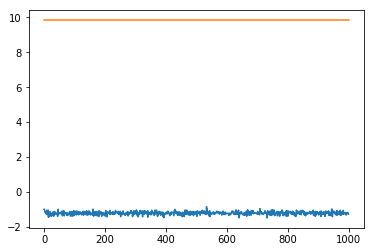

In [162]:
plt.plot(nutsTheta0[:,0,0])
plt.plot(nutsTheta0[:,0,2])

RHat statistics for the parameters are:  [1127.50322952  673.35764489  474.78502203  253.37492753  283.2510269
  229.68139869  139.46854694  285.29199113  126.04367673  303.37564715
  141.04345212  285.61143761   63.56892971   93.38005404  156.88556475
  287.25717765  219.03678772  207.68192154  121.6281824   179.83818999
  215.19554187  124.01077029  271.58084044  157.12336641  109.70414503]


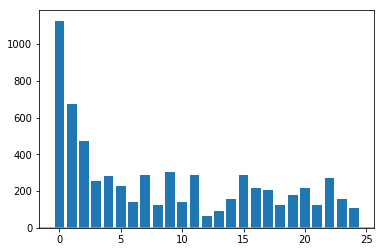

In [163]:
import ChainMix
importlib.reload(ChainMix)

nutsTheta1=np.zeros([size//4, 25, 8])
for i in range(4):
    nutsTheta1[:,:,i]=nutsTheta0[:size//4,:,i]
    nutsTheta1[:,:,i+1]=nutsTheta0[size//4:,:,i]

rHat=ChainMix.ChainMix(nutsTheta1)
print('RHat statistics for the parameters are: ', rHat)
plt.bar(range(len(rHat)),height=rHat)
plt.axhline(y=1.1, color='tab:orange')

### NUTS: effective sample size

vt0 (500, 25, 8)
tt (500,)
Effective sample size:  [ 4.00749824  4.04596542  4.23219466  4.44157126  6.60195099  4.379708
  6.02015686  6.36411251 17.55924253  5.80482753  8.88574677  4.39793427
  5.4412745  11.15110695  5.72124873  4.97329747  4.43336216  5.03556399
  4.91336314  4.75925887 10.13673322 15.01248082  8.89101979 22.44611908
 20.10465565]


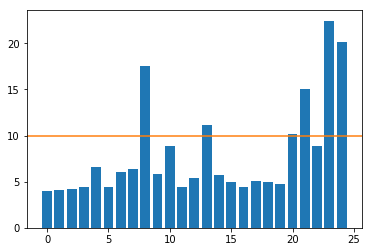

In [164]:
nutsEff=Neff.Neff(nutsTheta1)
print('Effective sample size: ', hmcEff)
plt.bar(range(len(hmcEff)),height=hmcEff)
plt.axhline(y=10.0, color='tab:orange')

### NUTS: comparison of the regression coefficients

Logistic regression coefficients (without sampling):  [[-1.16693394 -0.72428117  0.41863996 -0.38950509  0.14971296 -0.36499316
  -0.17983097 -0.15223281  0.0088167   0.17896626 -0.10547967 -0.23223442
   0.1752658   0.02906784 -0.13173154 -0.25096542  0.26151383 -0.3013166
   0.29946551  0.24939256  0.12501634 -0.06082535 -0.08394011 -0.01848919
  -0.00851217]]
sample coefficients:  [-13.46244959  -5.7475236    6.09310092  -2.75736809   5.07102135
  -2.47843563  -3.11404229  -1.85744563   3.16582774   5.40402906
   0.07057287  -1.77733128   1.93501746   0.85237532   2.50159424
  -1.005214     2.86004461  -3.29557888   4.5669522    5.77738113
   2.87526377   0.49672245  -0.42079341   1.06109312   0.86079727]
absolute difference of the coefficients:  [[12.3   5.02  5.67  2.37  4.92  2.11  2.93  1.71  3.16  5.23  0.18  1.55
   1.76  0.82  2.63  0.75  2.6   2.99  4.27  5.53  2.75  0.56  0.34  1.08
   0.87]]
(25,)


Text(0.5,1,'Absolute difference of logistic regression coefficients')

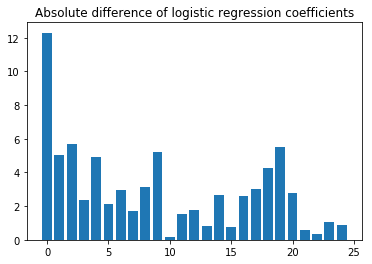

In [166]:
print('Logistic regression coefficients (without sampling): ', betaCoefficients)
nutsCoefficients=np.mean(nutsTheta1, axis=(0,2))
print('sample coefficients: ', nutsCoefficients)
print('absolute difference of the coefficients: ', np.round(abs(betaCoefficients-nutsCoefficients), 2))
height0=abs(betaCoefficients-nutsCoefficients)[0,:]
print(height0.shape)
plt.bar(range(len(height0)),height=height0)
plt.title('Absolute difference of logistic regression coefficients')

# Test case 3: Hierarchical bayesian logistic regression
* Same data as above

In [170]:
%reset
import autograd.numpy as np
import autograd.numpy.random as npr
# Download data and standardize X
# Should have values 1 or -1
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import HMC
import noUturnSampler
import ChainMix
import Neff
import importlib
importlib.reload(HMC)
importlib.reload(ChainMix)
importlib.reload(noUturnSampler)
importlib.reload(Neff)

credit0= pd.read_csv('dataGerman.tab', delim_whitespace=True)
creditY=np.array(credit0['CREDITRATING'])
credit0.insert(0, 'alpha', np.ones(len(credit0)))
creditX0=np.array(credit0.loc[:, credit0.columns != 'CREDITRATING'])
creditX=(creditX0 - np.mean(creditX0, axis=0))/np.std(creditX0, axis=0)
creditX[:,0]=1.0

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [172]:
# First parameter in theta is variance
# Rest are beta coefficients
def lBayesHLR(theta, x, y, lambda0=0.01):
    sigma2=np.exp(theta[0])
    beta=theta[1:]
    prob1=-np.sum(np.log(1+np.exp(-(y[:, np.newaxis]*x)@beta)))-1/(2*sigma2)*beta@beta-len(y)/2*np.log(sigma2)-lambda0*sigma2
    return prob1


lBayesHLRX=lambda theta0: lBayesHLR(theta0, creditX, creditY)

### HMC

In [176]:
# Calculate 4 chains with dispersed starting points
# Generate 25*1 vector as starting values for theta (=beta coefficients)
thetaOriginal1=np.zeros(26)
thetaOriginal2=npr.normal(-10.0, 5.0, 26)
thetaOriginal3=npr.normal(10.0, 5.0, 26)
thetaOriginal4=npr.normal(0.0, 5.0, 26)

# Sample size*2 (only the latter half is returned)
size=200
hmcTheta0=np.empty([size//2, 26, 4])
hmcTheta0[:,:,0], hmcR1 = HMC.basicHmc(thetaOriginal1, 0.1, 20, lBayesHLRX, size)
hmcTheta0[:,:,1], hmcR2 = HMC.basicHmc(thetaOriginal2, 0.1, 20, lBayesHLRX, size)
hmcTheta0[:,:,2], hmcR3 = HMC.basicHmc(thetaOriginal3, 0.1, 20, lBayesHLRX, size)
hmcTheta0[:,:,3], hmcR4 = HMC.basicHmc(thetaOriginal4, 0.1, 20, lBayesHLRX, size)


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:73: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)


All in all accepted:  200.0 , proportion:  1.0
Accepted:  99.0
Acceptance rate:  0.99
All in all accepted:  200.0 , proportion:  1.0
Accepted:  99.0
Acceptance rate:  0.99
All in all accepted:  200.0 , proportion:  1.0
Accepted:  99.0
Acceptance rate:  0.99


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\core.py:205: RuntimeWarning: invalid value encountered in double_scalars
  def _mut_add(self, x, y):    x += y; return x


All in all accepted:  200.0 , proportion:  1.0
Accepted:  99.0
Acceptance rate:  0.99


### NUTS

In [98]:
# Reload noUturnSampler-script always anew.
import importlib
importlib.reload(noUturnSampler)

thetaOriginal=np.zeros(26)
theta2Sample, epsilon2Sample = noUturnSampler.NoUTurn(thetaOriginal, 0.6, lBayesHLRX, 2000,1000, testRun=True)

First epsilon:  0.05
high bound:  1.120298280843218e-306
Likelihood:  -693.1571805599453  , 1/2*r0@r0:  11.320262924201623
***Starting iteration, round:  1
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -260.6576879392201
compared to Likelihood(theta0):  -693.1571805599453
Accepted new theta value, round:  1
Accepted likelihood:  -260.6576879392201
Going to direction:  1
BuildTree: j!=1, Likelihood(thetaCur) -284.9830994801309
Accepted new theta value, round:  1
Accepted likelihood:  -284.9830994801309
high bound:  2.5401796600439286e-129
Likelihood:  -284.9830994801309  , 1/2*r0@r0:  11.118142705271246
***Starting iteration, round:  2
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -3.4271060547304405e+120
compared to Likelihood(theta0):  -284.9830994801309
high bound:  2.010341590242148e-130
Likelihood:  -284.9830994801309  , 1/2*r0@r0:  13.654657956069084
***Starting iteration, round:  3
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -50260

C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


OverflowError: Range exceeds valid bounds

# Test case 4: compare your results with the same models run in Stan using the provided NUTS sampler
Pystan downloaded from :mc-stan.org/users/interfaces/pystan.html

## Test case 1: 250 dimensional multivariate normal

In [10]:
def fLNormal250(parTheta, matrixA):
    return -1/2*parTheta.T @ matrixA @ parTheta

# Generate 250*250 matrix for multivariate normal-distribution
from scipy.stats import wishart
precisionMatrixA=wishart.rvs(df=250, scale=1, size=[250, 250], random_state=None)
normal250likelihood=lambda x: fLNormal250(x, matrixA=precisionMatrixA)

# Generate 250*1 vector as starting values for theta
thetaOriginal=npr.normal(3.0, 3.0, size=250)


### HMC

In [13]:
import importlib
import HMC
importlib.reload(HMC)
thetaSample, rSample = HMC.basicHmc(thetaOriginal, 0.01, 100, normal250likelihood, 2000)

All in all accepted:  0.0 , proportion:  0.0
Accepted:  0.0
Acceptance rate:  0.0


In [36]:
print(thetaSample)

[[ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 [ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 [ 2.65564517 -5.39012071  7.46617946 ... -0.58202115  3.41668296
   0.82154097]
 ...
 [ 4.37834002 -8.7020084  12.86806496 ...  0.55830722  4.79958405
  -0.95769674]
 [ 4.39589425 -8.74859041 12.92832518 ...  0.57004154  4.81361664
  -0.97790908]
 [ 4.41621365 -8.7830764  12.98497566 ...  0.58387645  4.82169907
  -1.00058265]]


### No-U-Turn sampler

In [44]:
import noUturnSampler
import importlib
importlib.reload(noUturnSampler)
sample1UTurn, epsilon1sample=noUturnSampler.NoUTurn(thetaOriginal, 0.60, normal250likelihood, 1000,500, testRun=True)

#fig3, (plot1,plot2) = plt.subplots(nrows=1, ncols=2)
#plot1.hist(sample0UTurn[:,0])
#plot2.hist(sample0UTurn[:,1])
#print('Alpha value: ',np.mean(sample0UTurn[:,0]))
#print('Beta value: ', np.mean(sample0UTurn[:,1]))

Started FindReasonableEpsilon


C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Computational statistics II\noUturnSampler.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  while condition**a > 2.0**(-a):
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Computational statistics II\noUturnSampler.py:165: RuntimeWarning: overflow encountered in double_scalars
  condition=(np.exp(fLikelihood(thetaCur)-1/2*rCur@rCur-(fLikelihood(thetaOld)-1/2*rOld@rOld)))
C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Computational statistics II\noUturnSampler.py:165: RuntimeWarning: invalid value encountered in double_scalars
  condition=(np.exp(fLikelihood(thetaCur)-1/2*rCur@rCur-(fLikelihood(thetaOld)-1/2*rOld@rOld)))
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


Ending FindReasonableEpsilon
First epsilon:  0.00390625
high bound:  0.0
Likelihood:  -69800295.5256075  , 1/2*r0@r0:  124.0531725987402
***Starting iteration, round:  1
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -19068710.515499845
Accepted new theta value, round:  1
Accepted likelihood:  -19068710.515499845
high bound:  0.0
Likelihood:  -19068710.515499845  , 1/2*r0@r0:  137.4034403507699
***Starting iteration, round:  2
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -789594026545.2905
Accepted new theta value, round:  2
Accepted likelihood:  -789594026545.2905
high bound:  0.0
Likelihood:  -789594026545.2905  , 1/2*r0@r0:  113.0943310947806
***Starting iteration, round:  3
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -243719784534316.1
Accepted new theta value, round:  3
Accepted likelihood:  -243719784534316.1
high bound:  0.0
Likelihood:  -243719784534316.1  , 1/2*r0@r0:  127.17465722571372
***Starting iteration, round:  4
Going to

BuildTree: j!=1, Likelihood(thetaCur) -5518751876422.726
high bound:  0.0
Likelihood:  -5947731499721.149  , 1/2*r0@r0:  132.80635393076645
***Starting iteration, round:  25
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -83798744200644.97
Accepted new theta value, round:  25
Accepted likelihood:  -83798744200644.97
high bound:  0.0
Likelihood:  -83798744200644.97  , 1/2*r0@r0:  142.7843483424615
***Starting iteration, round:  26
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -59517774502260.42
Accepted new theta value, round:  26
Accepted likelihood:  -59517774502260.42
Going to direction:  -1
Accepted thetaCur2, Likelihood:  -14816855641246.172
BuildTree: j!=1, Likelihood(thetaCur) -14816855641246.172
Accepted new theta value, round:  26
Accepted likelihood:  -14816855641246.172
high bound:  0.0
Likelihood:  -14816855641246.172  , 1/2*r0@r0:  141.04178260802655
***Starting iteration, round:  27
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) 

Accepted thetaCur2, Likelihood:  -71982881797849.97
BuildTree: j!=1, Likelihood(thetaCur) -71982881797849.97
high bound:  0.0
Likelihood:  -132362320910.32362  , 1/2*r0@r0:  127.72037641493264
***Starting iteration, round:  50
Going to direction:  -1
BuildTree: j==0, Likelihood(thetaCur) -4993463243205.968
Accepted new theta value, round:  50
Accepted likelihood:  -4993463243205.968
high bound:  0.0
Likelihood:  -4993463243205.968  , 1/2*r0@r0:  134.07469837970552
***Starting iteration, round:  51
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -1636511898230.146
Accepted new theta value, round:  51
Accepted likelihood:  -1636511898230.146
high bound:  0.0
Likelihood:  -1636511898230.146  , 1/2*r0@r0:  121.31448470553138
***Starting iteration, round:  52
Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -5726951057851.718
Accepted new theta value, round:  52
Accepted likelihood:  -5726951057851.718
high bound:  0.0
Likelihood:  -5726951057851.718  , 1/2*r0@r0:  

Going to direction:  1
BuildTree: j==0, Likelihood(thetaCur) -4016036976.437084
Accepted new theta value, round:  100
Accepted likelihood:  -4016036976.437084
Going to direction:  -1
Accepted thetaCur2, Likelihood:  35196030.121625796
BuildTree: j!=1, Likelihood(thetaCur) 35196030.121625796
Accepted new theta value, round:  100
Accepted likelihood:  35196030.121625796
high bound:  inf
Likelihood:  35196030.121625796  , 1/2*r0@r0:  130.52282080018287


OverflowError: Range exceeds valid bounds